import relevant class(es) from w5,
make a cluster,
implement periodicity (minimum image convention) from article from w5,
move the atomic cluster around and check that you get the same energy

In [43]:
# from clustering import ExtremeNeighborCount

In [40]:
# import nbformat
# from IPython.core.interactiveshell import InteractiveShell

# # Path to your clustering notebook
# clustering_path = "//wsl.localhost/Ubuntu/home/justusperthes/repos/comPhys/Comphy/w4/clustering.ipynb"

# # Load the notebook
# with open(clustering_path) as f:
#     notebook = nbformat.read(f, as_version=4)

# # Create an InteractiveShell instance to execute the code cells
# shell = InteractiveShell.instance()

# # Execute each code cell in the notebook
# for cell in notebook.cells:
#     if cell.cell_type == 'code':
#         shell.run_cell(cell.source)


In [29]:
import os
print(os.listdir('//wsl.localhost/Ubuntu/home/justusperthes/repos/comPhys/Comphy/w4'))


['lj10clusters.txt', 'clustering.ipynb', 'Templates_19_20_21_23']


In [41]:
# import nbformat
# from IPython.core.interactiveshell import InteractiveShell

# # Load the notebook
# with open("//wsl.localhost/Ubuntu/home/justusperthes/repos/comPhys/Comphy/w4/clustering.ipynb") as f:
#     notebook = nbformat.read(f, as_version=4)

# # Create an InteractiveShell instance to execute the code cells
# shell = InteractiveShell.instance()

# # Execute each code cell in the notebook
# for cell in notebook.cells:
#     if cell.cell_type == 'code':
#         shell.run_cell(cell.source)


In [44]:
# import sys
# sys.path.append('//wsl.localhost/Ubuntu/home/justusperthes/repos/comPhys/Comphy/w4')
# import import_ipynb
# import clustering

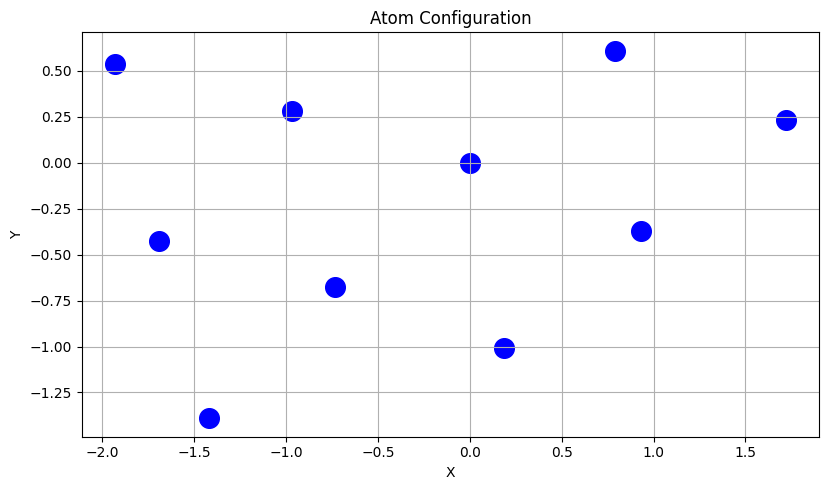

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

class Atomic_Cluster:
    
    def __init__(self, data_file, color='C4'):
        # Load and reshape position data
        self.positions = self.load_data(data_file)
        self.color = color

    def load_data(self, data_file):
        # Load and reshape position data
        pos_flat = np.loadtxt(data_file)
        return pos_flat.reshape(-1, pos_flat.shape[1] // 2, 2)

    # Calculate mean and standard deviation of pairwise distances
    def descriptor(self, pos):
        all_distances = pdist(pos)
        mean = np.mean(all_distances)
        std = np.std(all_distances)
        return np.array([mean, std])
    
    # Draw both the atom configuration and the bar plot of mean and std dev
    def draw(self, pos, ax):
        # Scatter plot of atom positions (atom configuration)
        ax.scatter(pos[:, 0], pos[:, 1], color='blue', s=200, label="Atoms")
        ax.set_title("Atom Configuration")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_aspect('equal')
        ax.grid(True)

    def plot_clusters(self, n_clusters):
        n_cols = 1  # Each cluster will use one column
        n_rows = n_clusters  # Number of clusters

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_clusters))

        # If there's only one cluster, axes will not be an array
        if n_clusters == 1:
            axes = [axes]  # Make it iterable

        for i in range(n_clusters):
            ax_scatter = axes[i]  # Access the axis
            self.draw(self.positions[i], ax_scatter)

        plt.tight_layout()
        plt.show()


hellow, mamain


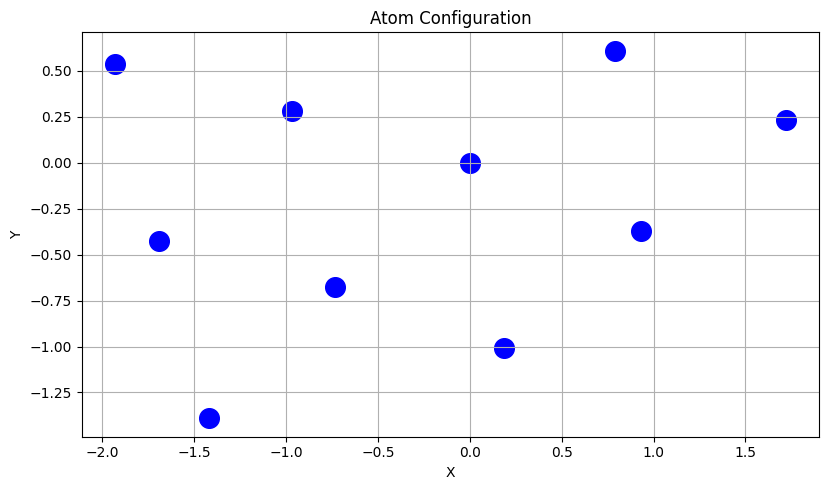

In [61]:
# extention of the relevant classes from w5 to incorporate periodicity

class Periodicity(Atomic_Cluster):
    ###
    def hellow_man(self):
        print("hellow, mamain")


data_file = 'lj10clusters.txt'  # Replace with your actual data file path if necessary
period = Periodicity(data_file)

period.hellow_man()

n_clusters = 1
period.plot_clusters(n_clusters)